 # **<center>  Lab 8 - DCT,WHT, SVD (Image)**</center> 
### **Problem Statement:**

$\color{blue}{\text{1.   Assume a Markov-1 process with covariance matrix R of size 8 × 8 and ρ = 0.91.
Compute the Energy Packing Efficiency}}$ $\color{blue}{\text{Efficiency and De-correlation of the Walsh-Haddamard Transform and Discrete Cosine Transform for the above process. What is your }}$

$\color{blue}{\text{observation about the eigenvectors of R in relation to the DCT basis? }}$



####**Solution:**

### 1. Importing required Libraries 

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

### 2. Function for Markov-1 Process
This function generates the covariance for a Markov-1 process with a given parameter $\rho$. The covariance matrix $R$ is given by

$$
R_{i,j} = \rho^{|i-j|}
$$

In [8]:
def R_Markov_1_Process(n, rho):
    x = np.arange(n)
    y = np.arange(n)
    X, Y = np.meshgrid(x, y)
    return rho**(np.abs(X-Y))

### 3. Function for Walsh Haddamard Transform
This function generates the Walsh Haddamard matrices $H_{n}$, are of the form $N \times N$ where $N = 2^{n}, n \in \{1, 2, ... \}$. All of these matrices can be generated from a core matrix $H_{1}$.

$$H_{1} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$

The higher order matrices can be generated from $H_{1}$ recursively as 

$$
H_{n} = H_{n-1}\otimes H_{1} = H_{1} \otimes H_{n-1}, \quad n \geq 2
$$


In [9]:
def Haddamard_matrix(n):
    WH1 = np.array(([1, 1], [1, -1]))/np.sqrt(2)
    WH = WH1.copy()
    if n == 1:
        return WH1
    else:
        for i in range(1, n):
            WH = np.kron(WH, WH1)
        return WH

### 4. Function for  2D Walsh Haddamard Transform
This Function performs 2D WHT using 1D WHT matrices. Given an image $U$ of the shape $m \times n$, its 2D WHT $V$ can be calculated as 

$$
V = H_{m}UH_{n}
$$

where $H_{i}$ is the 1D unitary H matrix of size $i \times i$. It must be noted that $(m, n)$ must be powers of $2$ for the transform to be applied.

In [10]:
def WHT_2D(image):
    x, y = np.shape(image)
    n_x = int(np.ceil(np.log2(x)))
    n_y = int(np.ceil(np.log2(y)))
    H_x = Haddamard_matrix(n_x)
    H_y = Haddamard_matrix(n_y)
    return H_x@image@(H_y.T)

### 5. Function for Discrete Cosine Transform
This function generates the matrix to perform unitary 1D type 2 DCT on an array of length $N$. The matrix $C$ has the form

$$
    C(k, n)= 
\begin{cases} \frac{1}{\sqrt{N}},        \text{if   } k= 0,  0 \leq n \leq N-1\\
    \sqrt{\frac{2}{N}}cos\left[\frac{\pi(2n+1)k}{2N}\right], \text{if } \quad 1 \leq k \leq N-1, \quad 0 \leq n \leq N-1
\end{cases}
$$




In [11]:
def DCT_matrix(N):
    n, k = np.meshgrid(np.arange(N), np.arange(N))
    C = np.sqrt(2/N)*(np.cos(np.pi*(2*n+1)*k/(2*N)))
    C[k == 0] = np.sqrt(1/N)
    return C

### 6. Function for 2D Discrete Cosine Transform
This function performs 2D DCT using 1D DCT matrices. Given an image $U$ of the shape $m \times n$, its 2D DCT $V$ can be calculated as 

$$
V = C_{m}UC_{n}
$$

where $C_{i}$ is the 1D unitary DCT matrix of size $i \times i$

In [12]:
def DCT_2D(image):
    m, n = np.shape(image)
    A = DCT_matrix(m)
    B = DCT_matrix(n)
    return A@image@(B.T)

### 7. Function for calculating Energy Packing Efficiency 
The energy packing effiency of a covariance matrix $R$ depends on the number of coeffieints we are using and what fraction of the energy can we pack in that. If we are using $m$ coefficients and there are total $N$ coefficients, the energy packing efficiency at $m$, $EPE_{m}$, is given by

$$
EPE_{m} = \frac{\Sigma_{i=1}^{m}R_{i, i}}{\Sigma_{i=1}^{N}R_{i, i}}
$$

Clearly the energy packing efficiency will be high even with low values of $m$ if the first few coefficients contain a bulk of the energy. It is to be noted than an inherent assumption is the coefficients are in the decreasing order, i.e., 

$$
R(1, 1) \geq R(2, 2) \dots \geq R(N, N)
$$

In [13]:
def EPE_vals(R):
    diag_vals = np.abs(np.diag(R))
    total_energy = np.sum(diag_vals)
    energy_packed = np.cumsum(diag_vals)
    return energy_packed/total_energy

### 8. Function for calculating Decorrelation Efficiency
The decorrelation efficiency measures how well the transformed data $R'$ is decorrelated compared to the original data $R$. It is defined as

$$
\eta = 1 - \frac{\alpha}{\beta}
$$

$$
\alpha = \Sigma_{i, j = 1, i \neq j}^{N}|R'_{i, j}|
$$

$$
\beta = \Sigma_{i, j = 1, i \neq j}^{N}|R_{i, j}|
$$

Clearly, for a given $R$, $\eta$ will be high when the off-diagonal elements in $R'$ are close to zero.

In [14]:
def decorrelation_efficiency(R, R_prime):
    n = np.shape(R)[0]
    non_diagonal_vals = 1-np.eye(n)
    R_ = np.abs(non_diagonal_vals*R)
    R_prime_ = np.abs(non_diagonal_vals*R_prime)
    alpha = np.sum(R_prime_)
    beta = np.sum(R_)
    eta = 1-(alpha/beta)
    return eta

In [15]:
# construct the R matrix
n = 8
rho = 0.91
R = R_Markov_1_Process(n, rho)

# Get the 2D DCT and WHT of R
R_DCT = DCT_2D(R)
R_WHT = WHT_2D(R)

# compute the energy packing and decorrelation efficiencies
epe_R_DCT = EPE_vals(R_DCT)
epe_R_WHT = EPE_vals(R_WHT)
de_R_DCT = decorrelation_efficiency(R, R_DCT)
de_R_WHT = decorrelation_efficiency(R, R_WHT)

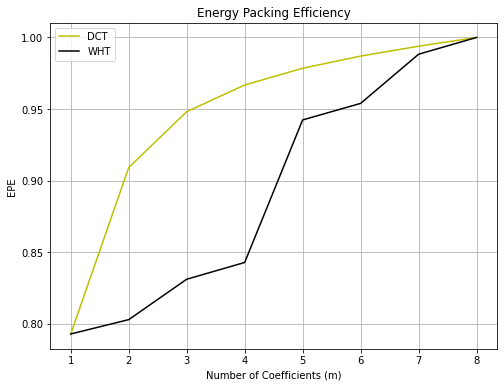

In [16]:
#Comparing Energy Packing Efficiency of DCT and WHT 
plt.figure(figsize=(8, 6))
plt.plot(np.arange(n)+1, epe_R_DCT, 'y')
plt.plot(np.arange(n)+1, epe_R_WHT, 'black')
plt.xlabel("Number of Coefficients (m)")
plt.ylabel("EPE")
plt.title("Energy Packing Efficiency")
plt.legend(["DCT", "WHT"])
plt.grid(True)
plt.show()

In [17]:
print(f"Decorrelation Efficiency of R for DCT : {de_R_DCT}")
print(f"Decorrelation Efficiency of R for WHT : {de_R_WHT}")

Decorrelation Efficiency of R for DCT : 0.9804711989227338
Decorrelation Efficiency of R for WHT : 0.9485667904674058



$\color{blue}{\text{2.    Find $β^2R^{-1}$, where $β^2=\frac {1-ρ^2}{1+\rho^2}$ Does $β^2R^{-1}$ have a tridiagonal structure?. Is it close to the tridiagonal matrix Q given by}}$
$\color{blue}{{
Q = \begin{bmatrix} 1-\alpha & -\alpha & 0 & 0 & 0 & 0& 0 & 0\\ -\alpha & 1 & -\alpha & 0 & 0 & 0& 0 & 0\\ 0 & -\alpha & 1 & -\alpha & 0 & 0& 0 & 0\\ 0 & 0 & -\alpha & 1& -\alpha& 0 & 0& 0 \\0 & 0 & 0& -\alpha & 1&-\alpha & 0 & 0\\0 & 0& 0 & 0 &-\alpha &1 & -α &0 \\ 0& 0 & 0& 0 & 0& -\alpha & 1&-\alpha \\0& 0 & 0& 0 & 0 & 0 & -\alpha & 1-α\end{bmatrix}}}$

$\color{blue}{\text{where $α= \frac {ρ}{1+\rho^2}$. Try diagonalising $β^2R^{-1}$ and $Q$ using the DCT matrix. What is your observation?}}$



### 8. Function for Tridiagonal Matrix
Generate a matrix with a tridiagonal structure for a given value of $\alpha$. For the purpose of illustration, a $4 \times 4$ tridiagonal matrix, $Q_{\alpha}$, is given by

$$Q_{\alpha} = \begin{bmatrix} 1-\alpha & -\alpha & 0 & 0 \\ -\alpha & 1 & -\alpha & 0 \\ 0 & -\alpha & 1 & -\alpha \\ 0 & 0 & -\alpha & 1-\alpha \end{bmatrix}$$

In [19]:
def tridiagonal_mat_Q(n, alpha):
    Q = np.zeros((n, n))
    x = np.arange(n)
    y = np.arange(n)
    X, Y = np.meshgrid(x, y)
    diff = np.abs(X-Y)
    Q[diff == 1] = -alpha
    Q[diff == 0] = 1
    Q[0, 0] = 1-alpha
    Q[-1, -1] = 1-alpha
    return Q

###9. Evaluating $β^2 R^{-1} $
If $R$ is the covariance matrix of a Markov-1 process with parameter $\rho$, its inverse, $R^{-1}$ satisfies

$$
\beta^{2}R^{-1} \approx Q_{\alpha}
$$

where,
$Q_{\alpha}$ is the tridiagonal matrix with parameter $\alpha$,

$$
\beta^{2} = \frac{1-\rho^{2}}{1+\rho^{2}}
$$

and, 

$$
\alpha = \frac{\rho}{1+\rho^{2}}
$$

In [18]:
alpha = rho/(1+rho**2)
beta_sqr = (1-rho**2)/(1+rho**2)

In [20]:
# generate the tridiagonal matrix Q
Q = tridiagonal_mat_Q(n, alpha)

# get the scaled inverse of R
beta_sqr_R_inv = beta_sqr*(np.linalg.inv(R))

# Diagonalize Q and scaled inverse of R using DCT
Q_DCT = DCT_2D(Q)
beta_sqr_R_inv_DCT = DCT_2D(beta_sqr_R_inv)

###10. Comparing $β^2 R^{-1} $ and $Q$ and their DCT

In [27]:
np.set_printoptions(precision=3,suppress=True)
print(beta_sqr_R_inv-Q)

[[ 0.045  0.    -0.     0.    -0.    -0.     0.    -0.   ]
 [ 0.    -0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.    -0.     0.     0.    -0.     0.    -0.   ]
 [-0.    -0.    -0.     0.    -0.     0.    -0.     0.   ]
 [-0.    -0.     0.    -0.     0.    -0.     0.    -0.   ]
 [-0.     0.    -0.     0.     0.    -0.    -0.     0.   ]
 [ 0.    -0.     0.     0.    -0.     0.    -0.     0.   ]
 [-0.     0.     0.    -0.     0.    -0.     0.     0.045]]


The above result shows that $\beta ^2R^{-1}$ is equal to the tridiagonal matrix $Q$ except for first and last element which are also approximately equal.

In [28]:
print(Q_DCT)

[[ 0.004  0.    -0.     0.     0.    -0.    -0.     0.   ]
 [-0.     0.08  -0.     0.    -0.    -0.     0.    -0.   ]
 [-0.    -0.     0.296  0.    -0.     0.    -0.     0.   ]
 [-0.     0.     0.     0.619  0.    -0.     0.    -0.   ]
 [ 0.    -0.    -0.     0.     1.     0.    -0.    -0.   ]
 [-0.    -0.     0.    -0.     0.     1.381  0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.     1.704 -0.   ]
 [ 0.    -0.     0.    -0.    -0.     0.    -0.     1.92 ]]


In [29]:
print(beta_sqr_R_inv_DCT )

[[ 0.016  0.     0.015  0.     0.011 -0.     0.006  0.   ]
 [ 0.     0.102 -0.     0.018  0.     0.012  0.     0.004]
 [ 0.015 -0.     0.315  0.     0.015  0.     0.008  0.   ]
 [-0.     0.018 -0.     0.634  0.     0.01   0.     0.004]
 [ 0.011 -0.     0.015  0.     1.011  0.     0.006  0.   ]
 [-0.     0.012 -0.     0.01   0.     1.388  0.     0.002]
 [ 0.006  0.     0.008  0.     0.006 -0.     1.707  0.   ]
 [-0.     0.004  0.     0.004 -0.     0.002 -0.     1.921]]


The above result shows that DCT diagonalises $Q$ (i.e. tridiagonal matrix)perfectly but struggles slightly to diagonalise $\beta ^2R^{-1}$.

$\color{blue}{\text{3. Compute SVD for the given 8 × 8 image}}$ **g**
$\color{blue}{\text{using the following steps:}}$

  $\color{blue}{\text{(a) Perform eigen-value decomposition of $g^Tg$ and $gg^T$.}}$

  $\color{blue}{\text{(b) Find the singular value matrix Σ.}}$

  $\color{blue}{\text{(c) Reconstruct the image using Σ and the eigen-vector matrices.}}$



###11. Reading the given image **g**

In [31]:
g = loadmat('imageFile.mat')['g']

## 12. Function for Singular Value Decomposition (SVD)
Given a matrix $g$, its $SVD$ is given as

$$
g = A\Sigma B^{T}
$$

$A$ is the matrix with the eigenvalues of $g g^{T}$ as its columns, $B$ is the matrix with the eigenvalues of $g^{T}g$, and $\Sigma$ is the matrix of singular values. Given a matrix $g$ we perform SVD on it using the following steps 
- Perform eigen-decomposition of $gg^{T}$ and $g^{T}g$
- Find the singular value matrix $\Sigma$ using the eigenvalues of $gg^{T}$ and $g^{T}g$
- Return $A, \Sigma, B$ as defined earlier

###13. Function for Sorted Eigenvectors
$\texttt{NumPy}$'s eigenvalue function does not give the eigenvectors sorted according to decreasing eigenvalue magnitudes. Sort it as it is needed for the calculation of $SVD$.

In [32]:
def sorted_eigenvals(Matrix):
    eigenValues, eigenVectors = np.linalg.eig(Matrix)
    idx = eigenValues.argsort()[::-1]
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues, eigenVectors

In [33]:
def SVD(g):
    g = g.astype(np.float64)
    m, n = np.shape(g)
    limiting_dim = min(m, n)
    sigma = np.zeros((m, n))
    S1 = g@(g.T)
    S2 = (g.T)@g
    e1, v1 = sorted_eigenvals(S1)
    e2, v2 = sorted_eigenvals(S2)
    for i in range(limiting_dim):
        sigma[i, i] = (np.sqrt(e1[i])+np.sqrt(e2[i]))/2
        v = v2[:, i]
        # This step is to ensure we have the correct pairing of the eigenvectors in the
        # A and B matrices. This is necessary as v and -v are eigenvectors of the same matrix
        # with the same eigenvalue
        if np.sum((g@v-sigma[i, i]*v1[:, i])**2) > np.sum((g@v+sigma[i, i]*v1[:, i])**2):
            v2[:, i] = -v
    return v1, sigma, v2

###14. Function for Reconstruction of Matrix
This function reconstructs a matrix $g$ from its $SVD$ matrices

$$
g = A\Sigma B^{T}
$$

In [35]:
def reconstruct_SVD(A, Sigma, B):
    return A@Sigma@(B.T)

### 15. Reconstruction of Image


In [38]:
# get SVD matrixes of g
A, Sigma, B = SVD(g)

# reconstruct g using all singular values
g_hat = reconstruct_SVD(A, Sigma, B)


In [39]:
print (g-g_hat)

[[-0.  0.  0. -0.  0.  0. -0. -0.]
 [ 0.  0. -0.  0.  0. -0. -0.  0.]
 [-0.  0.  0. -0. -0.  0.  0.  0.]
 [-0.  0.  0. -0. -0. -0.  0. -0.]
 [-0. -0. -0.  0.  0. -0.  0. -0.]
 [ 0. -0. -0.  0.  0.  0.  0. -0.]
 [ 0. -0.  0.  0. -0.  0. -0. -0.]
 [ 0. -0. -0.  0. -0. -0.  0. -0.]]


The above result shows that reconstructed image is exact same as original image. 

$\color{blue}{\text{4. Remove one singular value at a time from Σ and reconstruct the image $\widehat{(g_k)}$.}}$
$\color{blue}{\text{ Compute $||g-\widehat{(g_k)}||^2$ and compare it with the sum of the squares of the first k singular values.}}$

###16. Function for Reconstruction Error
Remove one singular value at a time from $\Sigma$ and reconstruct the image $\hat{g}_{k}$ where the $k$ highest singular values are removed. Compute the square of  Frobenius norm of the error between $\hat{g}_{k}$ and the original image $g$, i.e., $||g-\hat{g}_{k}||_{F}^{2}$

In [36]:
def reconstruction_errors_SVD(g, A, Sigma, B):
    g = g.astype(np.float64)
    m, n = np.shape(g)
    limiting_dim = min(m, n)
    reconstruction_errors = np.zeros(limiting_dim)
    # start with a copy of the original image
    reconstructed_matrix = g.copy()
    for i in range(limiting_dim):
        # remove the contribution of the ith singular value and its vectors
        reconstructed_matrix -= Sigma[i, i]*np.outer(A[:, i], B[:, i])
        # get the frobenius norm
        reconstruction_errors[i] = np.sum((reconstructed_matrix - g)**2)
    return reconstruction_errors

###17. Function for calculating Expected Reconstruction Error
On removing the $k$ highest singular values and reconstructing the image, the squared of the Frobenius norm of the error between the original image $g$ and the reconstructed image $\hat{g}_{k}$ is given by

$$
||g-\hat{g}_{k}||_{F}^{2} = \Sigma_{i=1}^{k}\sigma_{i}^{2}
$$

i.e., the sum of the squares of the first $k$ singular values

In [37]:
def theoretical_reconstruction_errors(Sigma):
    # get the non zero entries of the Sigma matrix
    sigma = Sigma[Sigma > 0]
    return np.cumsum(sigma**2)

In [ ]:
# get the theoretical and experimental reconstruction errors
reconstruction_errors_experimental = reconstruction_errors_SVD(g, A, Sigma, B)
reconstruction_errors_theoretical = theoretical_reconstruction_errors(Sigma)

In [42]:
print(reconstruction_errors_experimental-reconstruction_errors_theoretical)

[0. 0. 0. 0. 0. 0. 0. 0.]


The reconstruction errors obtained are exact similar to the ones we get theoretically.

### Reconstruction Errors
Remove one singular value at a time from $\Sigma$ and reconstruct the image $\hat{g}_{k}$ where the $k$ highest sigular values are removed. Compute the square of  Frobenius norm of the error between $\hat{g}_{k}$ and the original image $g$, i.e., $||g-\hat{g}_{k}||_{F}^{2}$. On removing the $k$ highest singular values and reconstructing the image, the squared of the Frobenius norm of the error between the original image $g$ and the reconstructed image $\hat{g}_{k}$ is given by

$$
||g-\hat{g}_{k}||_{F}^{2} = \Sigma_{i=1}^{k}\sigma_{i}^{2}
$$

i.e., the sum of the squares of the first $k$ singular values. 

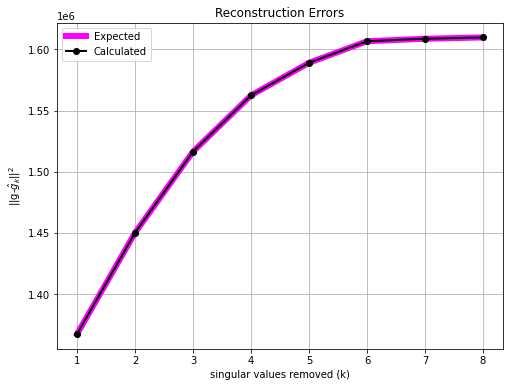

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(n)+1, reconstruction_errors_theoretical, 'magenta', linewidth=6)
plt.plot(np.arange(n)+1, reconstruction_errors_experimental,
         '-o', linewidth=2, color="black")
plt.xlabel("singular values removed (k)")
plt.ylabel(r'||g-$\hat{g}_{k}||^{2}$')
plt.legend(["Expected", "Calculated"])
plt.title("Reconstruction Errors")
plt.grid(True)
plt.show()

Both the theoretical and experimental values are plotted. It can be seen that the values are exactly the same.

#**Observations:**

By looking at the results obtained, the following observations can be made.

* DCT does a better job at energy packing and decorrelating the given covariance matix of Markov-1 process ($R$).
* Tridiagonal matrix $Q$ and $\beta^2R^{-1}$ are almost equal.
* DCT matrix perfectly diagonalises $Q$ matrix that has a tridiagonal structure but cannot diagonalise $\beta^2R^{-1}$ matrix with that perfection.
* Computation of $SVD$ of an image and its reconstruction using all singular values gives an exact reconstruction.
* The theoretical and experimental errors for reconstruction of image using singular values is found to be equal.



*Assumption: It is assumed that the imageFile.mat is available in the same directory.*